# Set Up code

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,\
    HistGradientBoostingClassifier,GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from torch.utils.data import DataLoader
from xgboost import XGBClassifier
from imblearn.over_sampling import ADASYN,RandomOverSampler
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [2]:
#mouting google drive to the notebook to retrive data files - not necessary if running locally
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Setting a PyTorch seed for the rest of the code
torch.manual_seed(71)
torch.cuda.manual_seed(71)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
train_path = r'/content/drive/MyDrive/_shared/Data-Mining/data-clean/train.csv'
# test_path = r'/content/drive/MyDrive/_shared/Data-Mining/data-clean/test.csv' Not used due to lack of labels available
df = pd.read_csv(train_path, low_memory=False)

In [16]:
df['Credit_Score'] = df['Credit_Score'].map({'Good': 0, 'Poor': 1, 'Standard': 2})

In [17]:
# Split the dataset into features and the label
X = df.drop('Credit_Score', axis=1)  # Replace 'label_column_name' with the actual column name of the label
y = df['Credit_Score']  # The label column

In [18]:
# Split the data - 80% training, 20% testing
X_train, X_test, labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=71)

In [19]:
len(labels)

80000

In [20]:
X_train.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
52694,84672,48725,7,Kimv,33.0,784169686.0,Accountant,16907.700,1212.944231,6.0,...,9.0,Bad,2887.41,27.213067,74.0,Yes,82.044258,23.883016,Low_spent_Large_value_payments,224.368765
45619,74061,20559,4,Guptap,30.0,235751663.0,Media_Manager,15548.340,1291.695000,7.0,...,11.0,Bad,1398.98,24.802695,210.0,Yes,58.154986,33.162773,Low_spent_Large_value_payments,274.329947
35571,58989,34281,4,Anna Driveri,45.0,288627562.0,Musician,20929.295,1704.107917,5.0,...,4.0,Good,858.09,26.292352,260.0,No,40.398175,21.651777,Low_spent_Small_value_payments,342.937266
78511,123397,20083,8,Yantoultra Nguic,47.0,493467198.0,Developer,113192.680,9376.723333,3.0,...,2.0,Good,1179.64,40.204174,228.0,No,0.000000,121.944556,Low_spent_Small_value_payments,735.919556
93071,145237,17260,8,Johnson Jilianq,52.0,807286080.0,Journalist,41942.100,3355.175000,0.0,...,6.0,Good,1303.34,37.202522,398.0,No,19.649050,34.341542,High_spent_Medium_value_payments,445.273448


In [21]:
X_test.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
88035,137685,27934,4,Steveu,43.0,549546864.0,Mechanic,16144.570,1280.380833,6.0,...,11.0,Bad,1496.51,23.265241,215.0,Yes,34.307808,44.335663,Low_spent_Small_value_payments,301.055453
43377,70699,35117,2,Guip,15.0,148151292.0,Manager,9427.945,921.662083,6.0,...,8.0,Bad,2358.57,24.520840,93.0,NM,48.094712,33.174890,Low_spent_Medium_value_payments,271.523174
88253,138011,25667,6,Gernot Hellerl,41.0,846270367.0,Developer,147781.640,12090.136667,0.0,...,3.0,Good,484.81,33.896689,230.0,No,0.000000,84.405999,High_spent_Medium_value_payments,1060.686258
2004,8638,31796,5,Norihiko Shirouzun,27.0,326054047.0,Entrepreneur,121688.040,10006.670000,7.0,...,4.0,Standard,54.68,40.188421,313.0,No,288.665455,75.129703,High_spent_Large_value_payments,832.570558
87510,136896,44995,7,Alister Bullv,24.0,270737020.0,Developer,14901.880,1362.823333,7.0,...,3.0,Standard,932.33,35.766078,236.0,No,7.293280,54.732280,Low_spent_Small_value_payments,302.383071


# Prepping Data For Models

In [22]:
'''Removing columns that provide any useful information.'''

all_features = X_train.columns.to_list()
values_to_remove = {'ID', 'Customer_ID', 'Month', 'Name', 'SSN'}
all_features = [x for x in all_features if x not in values_to_remove]
X_train = X_train[all_features]
X_test = X_test[all_features]
all_features

['Age',
 'Occupation',
 'Annual_Income',
 'Monthly_Inhand_Salary',
 'Num_Bank_Accounts',
 'Num_Credit_Card',
 'Interest_Rate',
 'Num_of_Loan',
 'Type_of_Loan',
 'Delay_from_due_date',
 'Num_of_Delayed_Payment',
 'Changed_Credit_Limit',
 'Num_Credit_Inquiries',
 'Credit_Mix',
 'Outstanding_Debt',
 'Credit_Utilization_Ratio',
 'Credit_History_Age',
 'Payment_of_Min_Amount',
 'Total_EMI_per_month',
 'Amount_invested_monthly',
 'Payment_Behaviour',
 'Monthly_Balance']

In [26]:
'''Feature List extracted from Random Forest Classifier feature importance scores in the aonther notebook '''
feature_list = ['Monthly_Inhand_Salary','Annual_Income', 'Amount_invested_monthly','Num_of_Delayed_Payment', 'Num_Bank_Accounts', 'Interest_Rate','Delay_from_due_date','Changed_Credit_Limit','Outstanding_Debt','Credit_History_Age', 'Credit_Score']
print(len(feature_list))
X_train = X_train[feature_list]
X_test = X_test[feature_list]

11


In [27]:
obj_to_num_dict={}
obj_to_num_dict['Month']={'January' : 1,
                          'February' : 2,
                          'March' : 3,
                          'April' : 4,
                          'May' : 5,
                          'June' : 6,
                          'July' : 7,
                          'August': 8,
                          'September':9,
                          'October':10,
                          'November':11,
                          'December':12}
num_to_obj_dict={}
def convert_str_to_num(df=X_train):
    """
    Function to convert all categorical columns in the dataframe to
    numerical values (starting from 0) while storing the mappings.

    Params:
        df - Pandas DataFrame

    Output:
        Returns the modified dataframe with all cotegorical columns coverted to numerical values.
    """
    # df=pd.get_dummies(df,columns=['Occupation'])
    for column in (df.select_dtypes(include='object').columns):

        obj_to_num_dict[column]={}
        num_to_obj_dict[column]={}

        for n,unique_value in enumerate(df[column].unique()):
            df[column]=df[column].replace( unique_value , n)
            obj_to_num_dict[ column][unique_value]= n
            num_to_obj_dict[ column][n+1]= unique_value

        df[column]=df[column].astype('uint8')

    return df


In [28]:
X_train = convert_str_to_num(X_train)

In [29]:
X_test = convert_str_to_num(X_test)

In [30]:
X_train.head()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
52694,33.0,0,16907.700,1212.944231,6.0,7.0,24.0,8.0,0,53.0,...,9.0,0,2887.41,27.213067,74.0,0,82.044258,23.883016,0,224.368765
45619,30.0,1,15548.340,1291.695000,7.0,10.0,33.0,5.0,1,39.0,...,11.0,0,1398.98,24.802695,210.0,0,58.154986,33.162773,0,274.329947
35571,45.0,2,20929.295,1704.107917,5.0,3.0,9.0,3.0,2,17.0,...,4.0,1,858.09,26.292352,260.0,1,40.398175,21.651777,1,342.937266
78511,47.0,3,113192.680,9376.723333,3.0,7.0,3.0,0.0,3,0.0,...,2.0,1,1179.64,40.204174,228.0,1,0.000000,121.944556,1,735.919556
93071,52.0,4,41942.100,3355.175000,0.0,3.0,1.0,1.0,4,8.0,...,6.0,1,1303.34,37.202522,398.0,1,19.649050,34.341542,2,445.273448


In [31]:
X_test.head()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
88035,43.0,0,16144.570,1280.380833,6.0,6.0,27.0,5.0,0,36.0,...,11.0,0,1496.51,23.265241,215.0,0,34.307808,44.335663,0,301.055453
43377,15.0,1,9427.945,921.662083,6.0,6.0,28.0,7.0,1,37.0,...,8.0,0,2358.57,24.520840,93.0,1,48.094712,33.174890,1,271.523174
88253,41.0,2,147781.640,12090.136667,0.0,4.0,4.0,0.0,2,6.0,...,3.0,1,484.81,33.896689,230.0,2,0.000000,84.405999,2,1060.686258
2004,27.0,3,121688.040,10006.670000,7.0,3.0,12.0,4.0,3,20.0,...,4.0,2,54.68,40.188421,313.0,2,288.665455,75.129703,3,832.570558
87510,24.0,2,14901.880,1362.823333,7.0,7.0,13.0,1.0,4,8.0,...,3.0,2,932.33,35.766078,236.0,2,7.293280,54.732280,0,302.383071


# EDA

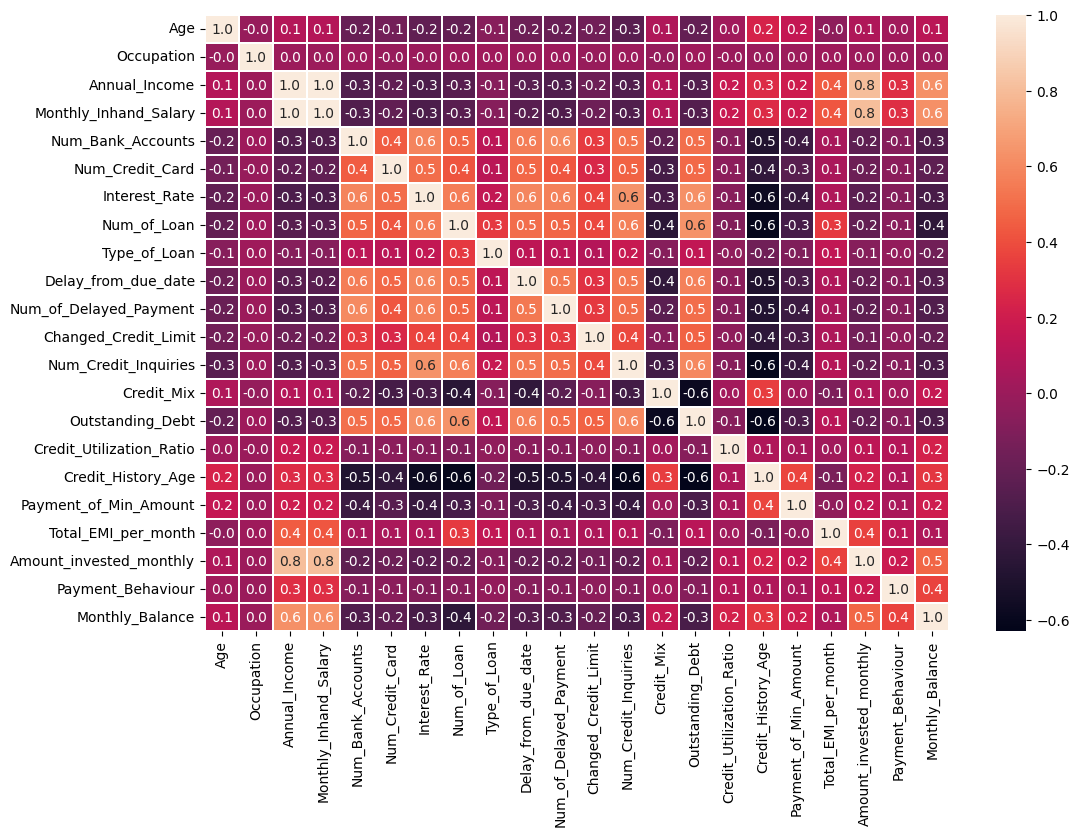

In [22]:
def correlation_plot(df=X_train):
    plt.figure(figsize=[12,8])
    sns.heatmap(df.select_dtypes(exclude='object')
                .dropna().corr(),annot=True,
                fmt='.1f',linewidth=.2)

correlation_plot()

#LSTM

In [25]:
# for row in labels:
#     print(row)

In [33]:
#converting each row from X_train into a tensor
feature_list = [torch.tensor(row) for _, row in X_train.iterrows()]

In [34]:
#converting each value from labels into a tensor
labels_list = [torch.tensor(value) for value in labels]

In [35]:
len(labels_list)

80000

In [30]:
# for tensor in feature_list:
#     if len(tensor) != 23:
#         print(len(tensor))

In [37]:
# Checking maximum and minimum index to correctly set the num_features for the LSTM later
max_index = max([torch.max(sublist).item() for sublist in feature_list if sublist.nelement() > 0])
min_index = min([torch.min(sublist).item() for sublist in feature_list if sublist.nelement() > 0])

print("Maximum index:", max_index)
print("Minimum index:", min_index)
del min_index

Maximum index: 179987.28
Minimum index: 0.0


In [39]:
# Convert lists to PyTorch tensors
features_tensor = torch.stack([data for data in feature_list])  # Stacking for creating a proper tensor
labels_tensor = torch.tensor(labels_list)

#NORMALISATION - did not improve results
# scaler = StandardScaler()
# features_tensor = torch.tensor(scaler.fit_transform(features_tensor.numpy()))

# Create a TensorDataset
dataset = TensorDataset(features_tensor, labels_tensor)

# Create a DataLoader
batch_size = 32  # You can modify the batch size depending on your specific requirements
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [41]:
import torch
import torch.nn as nn
class CustomLSTM_old(nn.Module): #Architecture mirroring LSTM discussed in 'https://arxiv.org/ftp/arxiv/papers/2012/2012.03754.pdf'
    def __init__(self, num_features):
        super(CustomLSTM, self).__init__()
        self.fc1 = nn.Linear(num_features, int(max_index + 1))
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(50, 50, batch_first=True)
        self.fc2 = nn.Linear(50, 3)  # Output layer for 3 classes

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = x.unsqueeze(1)  # Add sequence length dimension
        lstm_out, _ = self.lstm(x)
        x = self.fc2(lstm_out[:, -1, :])  # No sigmoid needed, raw logits are used
        return x

class CustomLSTM(nn.Module): # Improved version of the previous architecture
    """
    Feedforward layer with 50 outputs,
    followed by a linear layer, a 50 block LSTM,
    a dropout layer and another linear layer

    Params:
        num_features - Maximum index of the feature_list + 1
        embedding_dim - number of dimensions for the embedding layer

    Output:
        x - processed output for each batch
    """
    def __init__(self, num_features, embedding_dim=50):
        super(CustomLSTM, self).__init__()
        self.embedding = nn.Embedding(num_features, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, 50)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(50, 50, batch_first=True)  # ensure batch_first is True
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(50, 3)

    def forward(self, x):
        x = self.embedding(x)  # Ensure x is LongTensor, shape [batch, seq_len] --> [batch, seq_len, emb_dim]
        x = self.relu(self.fc1(x))  # Shape remains [batch, seq_len, 50]
        # No need to unsqueeze, LSTM expects [batch, seq_len, features] if batch_first=True
        lstm_out, _ = self.lstm(x)  # Correct shape to LSTM
        x = self.dropout(lstm_out[:, -1, :])  # Taking the last sequence output
        x = self.fc2(x)  # Final output
        return x


## Running LSTM

In [53]:
from tqdm.autonotebook import tqdm
from timeit import default_timer as timer
import torch.optim as optim
from sklearn.metrics import f1_score

In [57]:
# Example Usage
num_features = int(max_index + 1) #179988
model = CustomLSTM(num_features, 50)
loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr = 0.01)

In [58]:

def train_model(model, data_loader, num_epochs=3, patience=3):
    """
    Trains a neural network model performing training steps and calculating the loss
    at the end of each epoch, using the loss function, optimiser, and number of epochs given.
    Has a scheduler, optimser, loss criterion set up inside the function. Allows for early
    stpping for which the patience parameter can be adjusted.

    Args:
        model (torch.nn.Module): The model to train.
        data_loader (torch.utils.data.DataLoader): DataLoader serving the training data.
        num_epochs (int): Number of training epochs.
        patience (int): The device CPU/GPU where the model is trained.

    Returns:
        Nothing. The model itself is trained.
    """

    criterion = nn.CrossEntropyLoss()
    optimiser = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=10, gamma=0.1)
    best_loss = 10
    patience_counter = 0

    model.train()
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        loop=tqdm(data_loader)
        for batch, (inputs, labels) in enumerate(data_loader):
            loop.set_description(f"Batch [{batch+1}/{len(loop)}]")

            inputs = inputs.long() # Convert inputs to LongTensor
            labels = labels.long() # Ensure labels are long
            inputs, labels = inputs.to(device), labels.to(device)

            optimiser.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimiser.step()

            running_loss += loss.item()

        scheduler.step()
        epoch_loss = running_loss / len(data_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

        # Early stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

# Call the training function
train_model(model.to(device), data_loader, num_epochs=50, patience=5)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [1/50], Loss: 0.7861


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [2/50], Loss: 0.7070


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [3/50], Loss: 0.6449


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [4/50], Loss: 0.5775


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [5/50], Loss: 0.5230


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [6/50], Loss: 0.4846


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [7/50], Loss: 0.4594


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [8/50], Loss: 0.4373


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [9/50], Loss: 0.4191


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [10/50], Loss: 0.4078


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [11/50], Loss: 0.3665


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [12/50], Loss: 0.3574


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [13/50], Loss: 0.3523


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [14/50], Loss: 0.3476


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [15/50], Loss: 0.3440


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [16/50], Loss: 0.3423


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [17/50], Loss: 0.3383


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [18/50], Loss: 0.3369


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [19/50], Loss: 0.3339


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [20/50], Loss: 0.3323


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [21/50], Loss: 0.3258


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [22/50], Loss: 0.3246


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [23/50], Loss: 0.3250


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [24/50], Loss: 0.3239


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [25/50], Loss: 0.3244


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [26/50], Loss: 0.3235


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [27/50], Loss: 0.3236


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [28/50], Loss: 0.3228


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [29/50], Loss: 0.3230


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [30/50], Loss: 0.3224


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [31/50], Loss: 0.3214


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [32/50], Loss: 0.3212


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [33/50], Loss: 0.3208


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [34/50], Loss: 0.3220


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [35/50], Loss: 0.3221


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [36/50], Loss: 0.3201


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [37/50], Loss: 0.3206


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [38/50], Loss: 0.3209


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [39/50], Loss: 0.3213


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [40/50], Loss: 0.3210


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [41/50], Loss: 0.3222
Early stopping


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [1/50], Loss: 0.3810


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [2/50], Loss: 0.3696


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [3/50], Loss: 0.3564


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [4/50], Loss: 0.3474


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [5/50], Loss: 0.3364


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [6/50], Loss: 0.3273


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [7/50], Loss: 0.3197


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [8/50], Loss: 0.3121


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [9/50], Loss: 0.3055


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [10/50], Loss: 0.2985


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [11/50], Loss: 0.2609


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [12/50], Loss: 0.2483


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [13/50], Loss: 0.2419


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [14/50], Loss: 0.2369


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [15/50], Loss: 0.2330


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [16/50], Loss: 0.2298


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [17/50], Loss: 0.2252


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [18/50], Loss: 0.2235


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [19/50], Loss: 0.2206


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [20/50], Loss: 0.2173


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [21/50], Loss: 0.2113


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [22/50], Loss: 0.2094


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [23/50], Loss: 0.2090


  0%|          | 0/2500 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Evaluation

In [ ]:
X_test.columns

In [50]:
test_feature_list = [torch.tensor(row) for _, row in X_test.iterrows()]
test_labels_list = [torch.tensor(value) for value in test_labels]

# Convert lists to PyTorch tensors
test_features_tensor = torch.stack([data for data in test_feature_list])  # Stacking for creating a proper tensor
test_labels_tensor = torch.tensor(test_labels_list)

# Create a TensorDataset
test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)

# Create a DataLoader
batch_size = 32  # You can modify the batch size depending on your specific requirements
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [59]:
def evaluate_model(model, test_data_loader, device):
    """
    Function to evaluate model performance. Provides test accuracu and F1
    score for the test dataset.

    Args:
        model (torch.nn.Module): The model to train.
        test_data_loader (torch.utils.data.DataLoader): DataLoader serving the test data.
        device (torch.device): The device CPU/GPU where the model is trained.

    Output:
        None. Prints out the model's accuracy and F1 score.
    """

    model.eval()  # Set the model to evaluation mode
    model.to(device)
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data, labels in test_data_loader:
            data = data.to(device).long()  # Convert inputs to LongTensor and send to device
            labels = labels.to(device).long()  # Ensure labels are long and send to device
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.view(-1).cpu().numpy())  # Append batch predictions to list
            all_labels.extend(labels.view(-1).cpu().numpy())  # Append batch labels to list

    accuracy = 100 * np.mean(np.array(all_predictions) == np.array(all_labels))
    f1 = f1_score(all_labels, all_predictions, average='macro')  # Calculate macro F1 score
    print(f'Accuracy of the model on the test samples: {accuracy}%')
    print(f'F1 Score of the model on the test samples: {f1}')

    return accuracy, f1

# Example of how to call the function
accuracy, f1 = evaluate_model(model, test_data_loader, device)
print(f"Evaluated Model - Accuracy: {accuracy}%, F1 Score: {f1}")


Accuracy of the model on the test samples: 78.19500000000001%
F1 Score of the model on the test samples: 0.7768616257692843
Evaluated Model - Accuracy: 78.19500000000001%, F1 Score: 0.7768616257692843
